In [1]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd,jacrev
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *

from scipy.integrate import solve_ivp
from jax.scipy.linalg import block_diag

from jax.scipy.linalg import solve


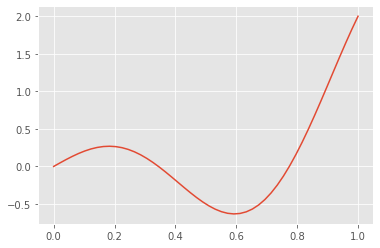

In [2]:
def f(x):
    return jnp.sin(2*jnp.pi*x)-3*jnp.cos(jnp.pi*x)*x - x
plt.plot(np.linspace(0,1,50),f(np.linspace(0,1,50)))

c = 2.1
def u_true_solution(tx):
    return f(tx[1] - c*tx[0])
u_true_function = jax.vmap(u_true_solution)

num_grid_points = 21
t,x = np.meshgrid(np.linspace(0,2,num_grid_points),np.linspace(0,1,num_grid_points))
tx_grid = np.vstack([t.flatten(),x.flatten()]).T

u_true = u_true_function(tx_grid)

x_t_vals = tx_grid
#Give data on left boundary

num_obs = 50

np.random.seed(15)
x_t_sample_inds = np.random.choice(range(20,len(tx_grid)),num_obs,replace = False)
obs_inds = x_t_sample_inds


tx_obs = tx_grid[obs_inds]

u_obs = u_true[obs_inds]
# plt.tricontourf(tx_obs[:,0],tx_obs[:,1],u_obs)
# plt.scatter(tx_obs[:,0],tx_obs[:,1])


k_u = get_gaussianRBF(0.1)

In [4]:
u_operators = [eval_k,dx_k,dt_k]
feature_operators = [eval_k,dx_k,dxx_k]

u_model = InducedRKHS(
    tx_grid,
    feature_operators,
    get_gaussianRBF(0.1)
    )

k_P = linear_kernel
class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params


class EqnModel():
    datafit_weight = 100

    @jit
    def get_grid_features(u_params):
        evaluation = u_model.evaluate_operators(feature_operators,tx_grid,u_params)
        grid_features = evaluation.reshape(len(tx_grid),len(feature_operators),order = 'F')
        return grid_features
    
    @jit
    def get_grid_target(u_params):
        return u_model.evaluate_operators([dt_k],tx_grid,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(tx_obs,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = EqnModel.eval_obs_points(u_params)
        return u_obs - obs_preds
    
    @jit
    def equation_residual(full_params):
        u_params = full_params[:u_model.num_params]
        P_params = full_params[u_model.num_params:]
        P_features = EqnModel.get_grid_features(u_params)
        P_model_preds = P_model.predict(P_features,P_params)
        ugrid_target = EqnModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(full_params):
        u_params = full_params[:u_model.num_params]
        eqn_res = EqnModel.equation_residual(full_params)
        data_res = EqnModel.datafit_residual(u_params)
        return jnp.hstack([
            EqnModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(full_params):
        return jnp.linalg.norm(EqnModel.F(full_params))**2
    
    @jit
    def damping_matrix(full_params):
        u_params = full_params[:u_model.num_params]
        grid_feats = EqnModel.get_grid_features(u_params)
        kmat_P = P_model.kernel_function(grid_feats,grid_feats)
        dmat = block_diag(
            u_model.kmat+1e-3 * diagpart(u_model.kmat),
            1e-2 * (kmat_P+1e-1 * jnp.identity(len(kmat_P)))
        )
        return dmat

In [5]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.zeros(u_model.num_params + len(tx_grid))

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    0.,
    max_iter = 501,
    init_alpha=200
)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 2.705e+03, Jres = 8.11e+05, alpha = 18.18
Iteration 1, loss = 2.048e+03, Jres = 3.937e+05, alpha = 92.05
Iteration 2, loss = 668.2, Jres = 3.8e+06, alpha = 18.18
Iteration 3, loss = 477.3, Jres = 6.378e+05, alpha = 16.53
Iteration 4, loss = 392.4, Jres = 4.623e+05, alpha = 15.03
Iteration 5, loss = 345.0, Jres = 1.451e+05, alpha = 13.66
Iteration 50, loss = 1.86, Jres = 746.1, alpha = 0.1874
Iteration 100, loss = 0.0177, Jres = 127.8, alpha = 0.001596
Iteration 150, loss = 0.004697, Jres = 32.3, alpha = 0.0005613
Iteration 200, loss = 0.003035, Jres = 36.07, alpha = 0.0007152
Iteration 250, loss = 0.002373, Jres = 115.9, alpha = 0.0005658
Iteration 300, loss = 0.002038, Jres = 9.951, alpha = 0.0006104
Iteration 350, loss = 0.001822, Jres = 22.21, alpha = 0.0007968
Iteration 400, loss = 0.001667, Jres = 19.87, alpha = 0.0006458
Iteration 450, loss = 0.001544, Jres = 10.64, alpha = 0.0006967
Iteration 500, loss = 0.001447, Jres = 1.666, alpha = 0.0006832


In [6]:
u_sol = params[:u_model.num_params]
P_sol = params[u_model.num_params:]

In [7]:
u_eval =u_model.point_evaluate(tx_grid,u_sol)

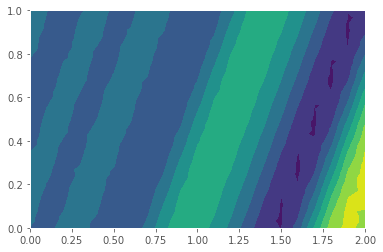

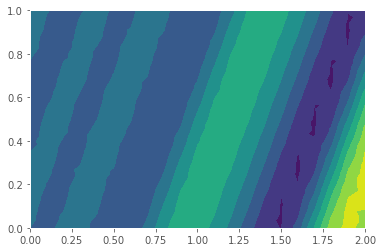

In [8]:
plt.tricontourf(tx_grid[:,0],tx_grid[:,1],u_eval)
plt.show()
plt.tricontourf(tx_grid[:,0],tx_grid[:,1],u_true)

In [9]:
grad_u_true = jax.vmap(grad(u_true_solution))(tx_grid)
hess_u_true = jax.vmap(hessian(u_true_solution))(tx_grid)

ut_true = grad_u_true[:,0]


ux_true = grad_u_true[:,1]
uxx_true = hess_u_true[:,1,1]

true_features = jnp.vstack([u_true,ux_true,uxx_true]).T

preds_ut = P_model.predict(EqnModel.get_grid_features(u_sol),P_sol)

In [10]:
jnp.mean((preds_ut-ut_true)**2)/jnp.var(ut_true)

Array(8.87083817e-05, dtype=float64)